In [2]:
!pip install xgboost

In [3]:
!pip install keras

In [4]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
raw_df = pd.read_csv('listings (1).csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

/Users/veohntiafokpa/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The dataset contains 49530 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2060,https://www.airbnb.com/rooms/2060,20200608144437,2020-06-09,Modern NYC,NaN,"Lovely, spacious, sunny 1 BR apartment in 6th ...","Lovely, spacious, sunny 1 BR apartment in 6th ...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/3755/3f9d3...,NaN,2259,https://www.airbnb.com/users/show/2259,Jenny,2008-08-18,US,NaN,a few days or more,0%,50%,f,https://a0.muscache.com/im/users/2259/profile_...,https://a0.muscache.com/im/users/2259/profile_...,Washington Heights,0.0,0.0,['reviews'],t,f,"New York, NY, United States",Washington Heights,Washington Heights,Manhattan,New York,NY,10040,New York,"New York, NY",US,United States,40.85722,-73.93790,t,Other,Private room,2,NaN,1.0,2.0,Real Bed,"{Internet,Wifi}",NaN,$100.00,NaN,NaN,NaN,NaN,1,$0.00,1,730,1,1,730,730,1.0,730.0,4 months ago,t,30,60,90,365,2020-06-09,1,0,2008-09-22,2008-09-22,80.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,0,1,0,0.01
1,2595,https://www.airbnb.com/rooms/2595,20200608144437,2020-06-09,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,84%,37%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, NY, United States",Manhattan,Midtown,Manhattan,New York,NY,10018,New York,"New York, NY",US,United States,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",NaN,$225.00,"$1,995.00",NaN,$350.00,$95.00,1,$0.00,3,1125,3,3,1125,1125,3.0,1125.0,3 months ago,t,3,30,60,335,2020-06-09,48,3,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10

In [6]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

In [7]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                          6
host_response_time                              27316
host_response_rate                              27316
host_acceptance_rate                            15396
host_is_superhost                                   6
host_listings_count                                 6
host_total_listings_count                           6
host_has_profile_pic                                6
host_identity_verified                              6
street                                              0
neighbourhood                                      11
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                              142
state                                               5
zipcode                                           429
market                      

In [8]:

df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

In [9]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

6


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4446862,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Crown Heights,Crown Heights,Brooklyn,NY,11238,New York,"Brooklyn, NY",US,United States,40.67512,-73.96146,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets live...",$50.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,61 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,NaN
4763327,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Greenpoint,Greenpoint,Brooklyn,NY,11211,New York,"Brooklyn, NY",US,United States,40.72035,-73.95355,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$195.00,$295.00,$70.00,2,$25.00,1,1125,1,1,1125,1125,1.0,1125.0,56 months ago,t,0,0,0,0,1,0,2015-10-20,2015-10-20,80.0,8.0,10.0,10.0,8.0,10.0,8.0,f,f,f,moderate,f,f,1,1,0,0,0.02
6360224,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Brooklyn,Bushwick,Brooklyn,NY,11206,New York,"Brooklyn, NY",US,United States,40.70146,-73.92792,t,Apartment,Private room,1,0.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Buz...",$37.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,60 months ago,t,0,0,0,0,1,0,2015-07-01,2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,0.02
6992973,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Brooklyn,Williamsburg,Brooklyn,NY,11249,New York,"Brooklyn, NY",US,United States,40.71838,-73.95630,t,Apartment,Entire home/apt,4,2.0,2.0,1.0,Real Bed,"{""Air conditioning"",Kitchen,""Pets allowed"",""Bu...",$145.00,"$1,000.00",$75.00,2,$50.00,1,1125,1,1,1125,1125,1.0,1125.0,60 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,1,0,0,NaN
7556587,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"New York, NY, United States",Hamilton Heights,Harlem,New York,NY,10032,New York,"New York, NY",US,United States,40.82929,-73.94182,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Wheelchair accessible"",Kitchen...",$28.00,NaN,NaN,1,$10.00,1,1125,1,1,1125,1125,1.0,1125.0,59 months ago,t,0,0,0,0,1,0,2015-08-01,2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,0.02


In [10]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [11]:
lat_long = df[['latitude', 'longitude']]

In [12]:

df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [13]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)


In [14]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)


In [15]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

## Cleaning Individual Columns

In [16]:
df.experiences_offered.value_counts()


none    49530
Name: experiences_offered, dtype: int64

In [17]:
df.drop('experiences_offered', axis=1, inplace=True)

In [18]:
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1334.0
Median days as host: 1365.0


In [19]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 27316
Proportion: 55.2%


/Users/veohntiafokpa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


11319

In [20]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.551504
within an hour        0.253341
within a few hours    0.099071
within a day          0.069009
a few days or more    0.027075
Name: host_response_time, dtype: float64

In [21]:
df.host_response_time.value_counts(normalize=True)

unknown               0.551504
within an hour        0.253341
within a few hours    0.099071
within a day          0.069009
a few days or more    0.027075
Name: host_response_time, dtype: float64

In [22]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 27316
Proportion: 55.2%


In [23]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 90.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.5%


In [24]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

unknown    27316
100%       15669
50-89%      3542
0-49%       1792
90-99%      1211
Name: host_response_rate, dtype: int64

In [25]:
# Number of rows without a value for multiple host-related columns
df.dropna(subset=['host_since'], inplace=True)


In [26]:
df.property_type.value_counts()


Apartment                 38488
House                      3932
Townhouse                  1804
Condominium                1752
Loft                       1335
Serviced apartment          486
Boutique hotel              455
Guest suite                 422
Hotel                       308
Other                       103
Guesthouse                   75
Resort                       73
Bed and breakfast            62
Hostel                       45
Aparthotel                   30
Villa                        29
Bungalow                     25
Tiny house                   23
Camper/RV                    17
Boat                          8
Cottage                       7
Earth house                   6
Tent                          5
Barn                          4
Cave                          4
Castle                        3
Houseboat                     3
Dome house                    3
Casa particular (Cuba)        3
Cabin                         2
Lighthouse                    2
Island  

In [27]:

# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [28]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [29]:
df.bed_type.value_counts()


Real Bed         48819
Futon              266
Pull-out Sofa      217
Airbed             149
Couch               61
Name: bed_type, dtype: int64

In [30]:
df.drop('bed_type', axis=1, inplace=True)


In [31]:
# Example of amenities listed
df.amenities[:1].values

array(['{Internet,Wifi}'], dtype=object)

In [32]:
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Bar',
 'Barbecue utensils',
 'Bath towel',
 'Bathrobes',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bluetooth speaker',
 'Body soap',
 'Bottled water',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide alarm',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Concierge',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around be

In [33]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/Users/veohntiafokpa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [34]:

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'breakfast', 'outdoor_space', 'hot_tub_sauna_or_pool', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


In [35]:
df.columns[40:]


Index(['air_conditioning', 'bed_linen', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'gym', 'child_friendly',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'self_check_in'],
      dtype='object')

In [36]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [37]:
df.security_deposit.isna().sum()


17180

In [38]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

In [39]:
df.cleaning_fee.isna().sum()


10859

In [40]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

In [41]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [42]:
print("Number of categories:", df.calendar_updated.nunique())
print("\nTop five categories:")
df.calendar_updated.value_counts()[:5]

Number of categories: 97

Top five categories:


3 months ago    7269
4 months ago    4340
5 months ago    2814
2 weeks ago     2788
2 months ago    2359
Name: calendar_updated, dtype: int64

In [43]:
df.drop('calendar_updated', axis=1, inplace=True)


In [44]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [45]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 22.9%
Null values in 'review_scores_rating': 24.8%


In [46]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

In [47]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [48]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [49]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

In [50]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

In [53]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [54]:
df.cancellation_policy.value_counts()


strict_14_with_grace_period    21573
flexible                       16505
moderate                       11372
super_strict_60                   58
super_strict_30                   15
strict                             1
Name: cancellation_policy, dtype: int64

In [55]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

In [56]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [57]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 18 August 2008, and the most recent joined on 07 June 2020.


In [59]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [60]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,host_days_active,air_conditioning,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,self_check_in,time_since_last_review
count,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,4.952400e+04,49524.000000,49524.000000,37207.000000,37221.000000,37194.000000,37211.000000,37191.000000,37192.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,38207.000000
mean,0.191483,18.143748,0.439120,2.836483,1.148998,1.186233,1.532489,162.651967,177.614207,54.937969,1.500424,13.598175,8.192149,8.813228e+04,40.051127,23.870225,9.604779,9.272615,9.731032,9.729730,9.594875,9.381265,0.360492,1334.076872,0.847125,0.324045,0.694653,0.342622,0.369861,0.465734,0.256603,0.101809,0.245659,0.432578,0.136035,0.975830,0.201801,0.179489,0.220923,0.203679,-8.068312
std,0.393472,135.457329,0.496285,1.875267,0.435268,0.766625,1.135178,419.336518,442.760528,65.603354,1.154371,23.796802,21.976030,1.364744e+07,40.296561,48.248112,0.890308,1.116757,0.772432,0.807332,0.778699,0.970009,0.480148,919.010497,0.359871,0.468022,0.460559,0.474591,0.482772,0.498829,0.436763,0.302400,0.430481,0.495438,0.342829,0.153579,0.401349,0.383765,0.414873,0.402737,492.445506
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,-425.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-427.000000
25%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,68.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.900000e+01,0.000000,1.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,650.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-334.000000
50%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,101.000000,0.000000,40.000000,1.000000,0.000000,3.000000,6.000000e+02,30.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,1365.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-258.000000
75%,0.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.000000,175.000000,200.000000,80.000000,2.000000,20.000000,6.000000,1.125000e+03,88.000000,23.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,2008.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,154.000000
max,1.000000,1941.000000,1.000000,22.000000,15.500000,21.000000,40.000000,10000.000000,5100.000000,1000.000000,16.000000,300.000000,1250.000000,2.147484e+09,90.000000,746.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,3886.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3851.000000


In [61]:
print(f"Nightly advertised prices range from ${min(df.price)} to ${max(df.price)}.")

Nightly advertised prices range from $0 to $10000.


In [62]:
# Replacing values under $10 with $10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
df.loc[df.price >= 1000, 'price'] = 1000

In [63]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 18
54% of listings are from hosts with one listing.


In [64]:
df.host_identity_verified.value_counts(normalize=True)


0.0    0.56088
1.0    0.43912
Name: host_identity_verified, dtype: float64

In [65]:
transformed_df = pd.get_dummies(df)


In [66]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

In [67]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

In [68]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [69]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [70]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Second Model: Three Layer Neural Network

In [71]:
! pip install tensorflow

In [72]:
! pip install pydot
! pip install graphviz
! pip install geopandas

! pip install pydotplus


In [73]:
# Dependencies for new models we are trying

from keras import models, layers, optimizers, regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers.advanced_activations import LeakyReLU

In [74]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [75]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [76]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [77]:
np.any(np.isnan(X_train))

False

In [78]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               36352     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 135,425
Trainable params: 135,425
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Epoch 1/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2208 - mean_squared_error: 2.2208 - val_loss: 0.3336 - val_mean_squared_error: 0.3336
Epoch 2/100
140/140 [==============================] - 0s 2ms/step - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.2467 - val_mean_squared_error: 0.2467
Epoch 3/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1943 - mean_squared_error: 0.1943 - val_loss: 0.2183 - val_mean_squared_error: 0.2183
Epoch 4/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1742 - mean_squared_error: 0.1742 - val_loss: 0.2096 - val_mean_squared_error: 0.2096
Epoch 5/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1642 - mean_squared_error: 0.1642 - val_loss: 0.2040 - val_mean_squared_error: 0.2040
Epoch 6/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.1950 - val_mean_squared_error: 0.1950
Epoch 7/100
140/140 [=

140/140 [==============================] - 0s 3ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.2611 - val_mean_squared_error: 0.2611
Epoch 52/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.2613 - val_mean_squared_error: 0.2613
Epoch 53/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.2652 - val_mean_squared_error: 0.2652
Epoch 54/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.2599 - val_mean_squared_error: 0.2599
Epoch 55/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.2819 - val_mean_squared_error: 0.2819
Epoch 56/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.2526 - val_mean_squared_error: 0.2526
Epoch 57/100
140/140 [=======

In [80]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0428
Validation MSE: 0.2206

Training r2: 0.9103
Validation r2: 0.5436


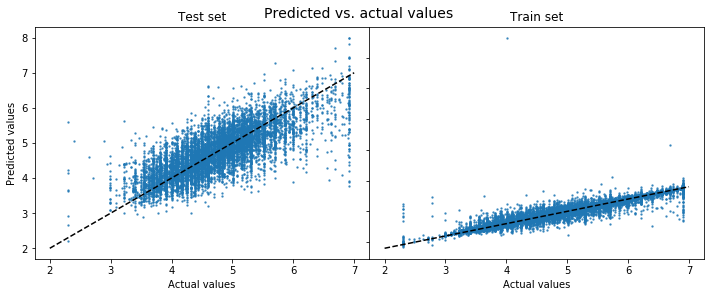

In [81]:
nn_model_evaluation(nn2)

# Model 3: Four layer neural network

In [82]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               36352     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 267,265
Trainable params: 267,265
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Epoch 1/150
140/140 [==============================] - 1s 4ms/step - loss: 40.8059 - mean_squared_error: 2.0201 - val_loss: 19.5055 - val_mean_squared_error: 0.2677
Epoch 2/150
140/140 [==============================] - 1s 4ms/step - loss: 12.1674 - mean_squared_error: 0.2156 - val_loss: 7.0653 - val_mean_squared_error: 0.2046
Epoch 3/150
140/140 [==============================] - 1s 4ms/step - loss: 4.6429 - mean_squared_error: 0.1894 - val_loss: 2.9215 - val_mean_squared_error: 0.2105
Epoch 4/150
140/140 [==============================] - 1s 4ms/step - loss: 2.0605 - mean_squared_error: 0.1990 - val_loss: 1.4427 - val_mean_squared_error: 0.2133
Epoch 5/150
140/140 [==============================] - 1s 4ms/step - loss: 1.0978 - mean_squared_error: 0.1952 - val_loss: 0.8637 - val_mean_squared_error: 0.2070
Epoch 6/150
140/140 [==============================] - 1s 4ms/step - loss: 0.7152 - mean_squared_error: 0.1889 - val_loss: 0.6419 - val_mean_squared_error: 0.2014
Epoch 7/150
140/140

Epoch 51/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3621 - mean_squared_error: 0.1715 - val_loss: 0.3784 - val_mean_squared_error: 0.1878
Epoch 52/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3627 - mean_squared_error: 0.1718 - val_loss: 0.3785 - val_mean_squared_error: 0.1882
Epoch 53/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3616 - mean_squared_error: 0.1713 - val_loss: 0.3777 - val_mean_squared_error: 0.1877
Epoch 54/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3615 - mean_squared_error: 0.1711 - val_loss: 0.3770 - val_mean_squared_error: 0.1870
Epoch 55/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3615 - mean_squared_error: 0.1716 - val_loss: 0.3760 - val_mean_squared_error: 0.1861
Epoch 56/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3610 - mean_squared_error: 0.1712 - val_loss: 0.3788 - val_mean_squared_error: 0.1883
Epoch 57/150
140

Epoch 101/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3580 - mean_squared_error: 0.1720 - val_loss: 0.3735 - val_mean_squared_error: 0.1875
Epoch 102/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3578 - mean_squared_error: 0.1718 - val_loss: 0.3729 - val_mean_squared_error: 0.1872
Epoch 103/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3575 - mean_squared_error: 0.1718 - val_loss: 0.3751 - val_mean_squared_error: 0.1890
Epoch 104/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3584 - mean_squared_error: 0.1728 - val_loss: 0.3719 - val_mean_squared_error: 0.1864
Epoch 105/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3571 - mean_squared_error: 0.1717 - val_loss: 0.3746 - val_mean_squared_error: 0.1892
Epoch 106/150
140/140 [==============================] - 1s 4ms/step - loss: 0.3574 - mean_squared_error: 0.1719 - val_loss: 0.3743 - val_mean_squared_error: 0.1880
Epoch 107/

140/140 [==============================] - 1s 4ms/step - loss: 0.3533 - mean_squared_error: 0.1718 - val_loss: 0.3680 - val_mean_squared_error: 0.1869
Time taken to run: 1.5 minutes


Training MSE: 0.1705
Validation MSE: 0.1693

Training r2: 0.643
Validation r2: 0.6499


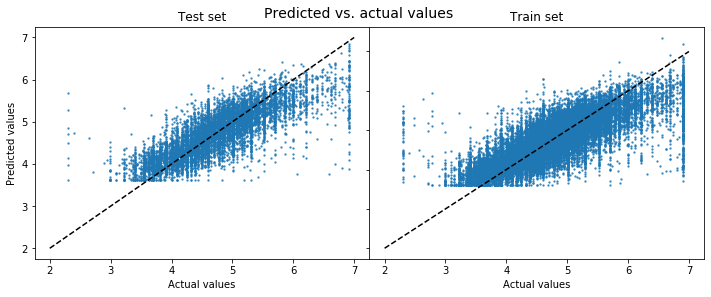

In [84]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

# Model 4: Neural Network with SGD Optimizer

In [85]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               36352     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 267,265
Trainable params: 267,265
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Epoch 1/150
140/140 [==============================] - 1s 4ms/step - loss: 65.1269 - mean_squared_error: 1.6628 - val_loss: 59.2528 - val_mean_squared_error: 0.2949
Epoch 2/150
140/140 [==============================] - 1s 4ms/step - loss: 55.0272 - mean_squared_error: 0.2363 - val_loss: 50.8767 - val_mean_squared_error: 0.2422
Epoch 3/150
140/140 [==============================] - 1s 4ms/step - loss: 47.0040 - mean_squared_error: 0.2067 - val_loss: 43.2019 - val_mean_squared_error: 0.2239
Epoch 4/150
140/140 [==============================] - 1s 4ms/step - loss: 39.6617 - mean_squared_error: 0.1950 - val_loss: 36.1949 - val_mean_squared_error: 0.2146
Epoch 5/150
140/140 [==============================] - 1s 4ms/step - loss: 32.9795 - mean_squared_error: 0.1887 - val_loss: 29.8402 - val_mean_squared_error: 0.2097
Epoch 6/150
140/140 [==============================] - 0s 4ms/step - loss: 26.9476 - mean_squared_error: 0.1862 - val_loss: 24.1385 - val_mean_squared_error: 0.2063
Epoch 7/15

Epoch 51/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2674 - mean_squared_error: 0.1752 - val_loss: 0.2876 - val_mean_squared_error: 0.1950
Epoch 52/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2668 - mean_squared_error: 0.1749 - val_loss: 0.2811 - val_mean_squared_error: 0.1893
Epoch 53/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2662 - mean_squared_error: 0.1747 - val_loss: 0.2827 - val_mean_squared_error: 0.1909
Epoch 54/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2657 - mean_squared_error: 0.1747 - val_loss: 0.2807 - val_mean_squared_error: 0.1898
Epoch 55/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2656 - mean_squared_error: 0.1753 - val_loss: 0.2827 - val_mean_squared_error: 0.1926
Epoch 56/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2641 - mean_squared_error: 0.1747 - val_loss: 0.2823 - val_mean_squared_error: 0.1920
Epoch 57/150
140

Epoch 101/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2544 - mean_squared_error: 0.1737 - val_loss: 0.2700 - val_mean_squared_error: 0.1893
Epoch 102/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2536 - mean_squared_error: 0.1733 - val_loss: 0.2712 - val_mean_squared_error: 0.1904
Epoch 103/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2546 - mean_squared_error: 0.1740 - val_loss: 0.2689 - val_mean_squared_error: 0.1886
Epoch 104/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2545 - mean_squared_error: 0.1742 - val_loss: 0.2738 - val_mean_squared_error: 0.1932
Epoch 105/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2538 - mean_squared_error: 0.1738 - val_loss: 0.2711 - val_mean_squared_error: 0.1910
Epoch 106/150
140/140 [==============================] - 1s 4ms/step - loss: 0.2534 - mean_squared_error: 0.1737 - val_loss: 0.2788 - val_mean_squared_error: 0.1973
Epoch 107/

140/140 [==============================] - 1s 4ms/step - loss: 0.2485 - mean_squared_error: 0.1709 - val_loss: 0.2650 - val_mean_squared_error: 0.1873
Time taken to run: 1.5 minutes


Training MSE: 0.1746
Validation MSE: 0.1705

Training r2: 0.6343
Validation r2: 0.6472


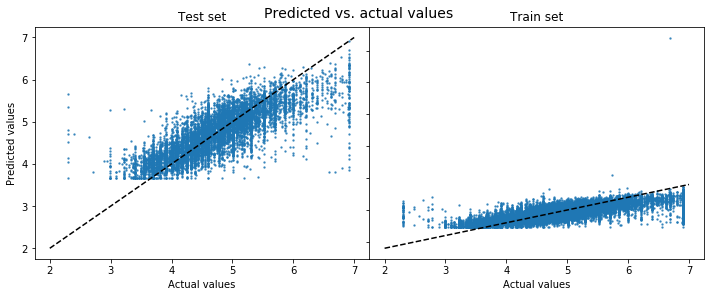

In [87]:
nn_model_evaluation(nn4, skip_epochs=10)

# Model 5: neural network with dropout regularization at 50%

In [88]:

# Building the model
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 283)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               36352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [89]:

# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

Epoch 1/50
140/140 [==============================] - 1s 4ms/step - loss: 5.8113 - mean_squared_error: 5.8113 - val_loss: 4.3578 - val_mean_squared_error: 4.3578
Epoch 2/50
140/140 [==============================] - 1s 4ms/step - loss: 1.8376 - mean_squared_error: 1.8376 - val_loss: 4.1621 - val_mean_squared_error: 4.1621
Epoch 3/50
140/140 [==============================] - 1s 4ms/step - loss: 1.2844 - mean_squared_error: 1.2844 - val_loss: 3.7233 - val_mean_squared_error: 3.7233
Epoch 4/50
140/140 [==============================] - 1s 4ms/step - loss: 1.0613 - mean_squared_error: 1.0613 - val_loss: 3.3549 - val_mean_squared_error: 3.3549
Epoch 5/50
140/140 [==============================] - 1s 4ms/step - loss: 0.8357 - mean_squared_error: 0.8357 - val_loss: 2.7050 - val_mean_squared_error: 2.7050
Epoch 6/50
140/140 [==============================] - 1s 4ms/step - loss: 0.7178 - mean_squared_error: 0.7178 - val_loss: 1.6739 - val_mean_squared_error: 1.6739
Epoch 7/50
140/140 [========

Training MSE: 0.2299
Validation MSE: 0.2351

Training r2: 0.5186
Validation r2: 0.5137


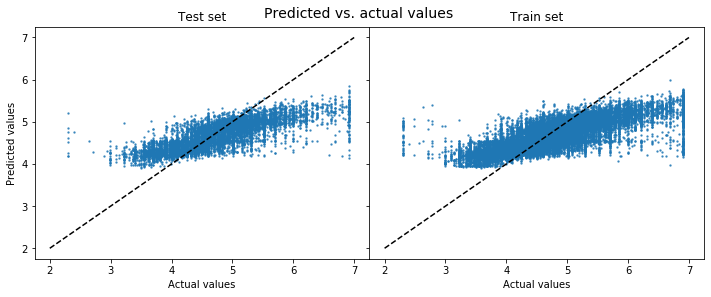

In [90]:
nn_model_evaluation(nn5, skip_epochs=2)

In [95]:
# Ridge Method to see how it now compares
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.7)
reg.fit(X_train, y_train)

Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [92]:
reg.score(X_test, y_test)

0.6405298524183329

In [93]:
# SVR Method
from sklearn import svm
reg2 = svm.SVR(kernel='rbf')
reg2.fit(X_train, y_train)

/Users/veohntiafokpa/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [94]:
reg2.score(X_test, y_test)

0.6722187877619674